In [7]:
import sys
import os
sys.path.append("/content/ml-project-2-pytyeee/")

REPO_DIR = "ml-project-2-pytyeee/"

In [138]:
import segmentation_models_pytorch as smp
from scripts.preprocessing import *
from torch.utils.data import DataLoader, TensorDataset
import torch

TRAINING

In [115]:
NUM_CPU = 2 # os.cpu_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

TRAINING_SIZE = 500
BATCH_SIZE = 32
NUM_EPOCHS = 30
BASE_LR = 0.0001

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

cuda


In [117]:
train_dir = REPO_DIR + "dataset/training/"
train_images_filename = train_dir + "augmented_images/"
train_masks_filename = train_dir + "augmented_groundtruth/"

train_images = extract_data(train_images_filename, TRAINING_SIZE)
train_masks = extract_data(train_masks_filename, TRAINING_SIZE)
print(f"Input shapes: {train_images.shape, train_masks.shape}")

Loading ml-project-2-pytyeee/dataset/training/augmented_images/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_images/satImage_500.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth/satImage_001.png
Loading ml-project-2-pytyeee/dataset/training/augmented_groundtruth/satImage_500.png
Input shapes: ((500, 400, 400, 3), (500, 400, 400))


In [118]:
# Resize images to a size divisible by 32 to make it UNet compatible
train_data = img_resize(np.transpose(train_images, (0, 3, 1, 2)), (416, 416))
train_labels = img_resize(np.transpose(np.expand_dims(train_masks, -1), (0, 3, 1, 2)),  (416, 416))

# 1 hot encode each non black pixel to 1 pixel
train_labels[train_labels > 0] = 1
print(f"New shapes: {train_data.shape, train_labels.shape}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

New shapes: (torch.Size([500, 3, 416, 416]), torch.Size([500, 1, 416, 416]))


In [119]:
# Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1, # 1 for grayscale
    activation=ACTIVATION,
)

model = model.to(DEVICE)
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [120]:
# Create dataset
road_dataset = TensorDataset(train_data, train_labels)

# Get train and val data loaders
train_loader = DataLoader(road_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_CPU)

In [121]:
# define loss
criterion = smp.losses.DiceLoss('binary')

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [122]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    # ***************************************************
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()

    loss_history = []
    accuracy_history = []
    f1_history = []
    lr_history = []

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move the data to the device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute model output
        output = model(data)
        # Compute loss
        loss = criterion(output, target)
        # Backpropagate loss
        loss.backward()
        # Perform an optimizer step
        optimizer.step()
        # Perform a learning rate scheduler step
        scheduler.step()
        # Compute accuracy_float (float value, not a tensor)
        pred = torch.where(output > 0.5, 1., 0.)
        accuracy_float = torch.sum((pred==target)) / torch.numel(target)
        # Compute loss_float (float value, not a tensor)
        loss_float = loss.item()
        # Add loss_float to loss_history
        loss_history.append(loss_float)
        # Add accuracy_float to accuracy_history
        accuracy_history.append(accuracy_float)
        # Add learning rate to lr_history
        lr_history.append(scheduler.get_last_lr()[0])

        print(
            f"Train Epoch: {epoch}-{batch_idx:03d} "
            f"batch_loss={loss_float:0.2e} "
            f"batch_acc={accuracy_float:0.3f} "
            f"lr={scheduler.get_last_lr()[0]:0.3e} "
        )

    return loss_history, accuracy_history, lr_history, output, target

In [123]:
lr_history = []
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc, lrs, output, target = train_epoch(
        model, optimizer, lr_scheduler, criterion, train_loader, epoch, DEVICE
    )
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    lr_history.extend(lrs)

Train Epoch: 1-000 batch_loss=6.70e-01 batch_acc=0.324 lr=1.000e-04 
Train Epoch: 1-001 batch_loss=6.78e-01 batch_acc=0.325 lr=7.500e-05 
Train Epoch: 1-002 batch_loss=6.66e-01 batch_acc=0.336 lr=1.000e-04 
Train Epoch: 1-003 batch_loss=7.03e-01 batch_acc=0.327 lr=9.268e-05 
Train Epoch: 1-004 batch_loss=6.62e-01 batch_acc=0.360 lr=7.500e-05 
Train Epoch: 1-005 batch_loss=6.85e-01 batch_acc=0.354 lr=5.732e-05 
Train Epoch: 1-006 batch_loss=6.52e-01 batch_acc=0.384 lr=1.000e-04 
Train Epoch: 1-007 batch_loss=6.91e-01 batch_acc=0.362 lr=9.810e-05 
Train Epoch: 1-008 batch_loss=6.72e-01 batch_acc=0.393 lr=9.268e-05 
Train Epoch: 1-009 batch_loss=6.91e-01 batch_acc=0.395 lr=8.457e-05 
Train Epoch: 1-010 batch_loss=6.69e-01 batch_acc=0.419 lr=7.500e-05 
Train Epoch: 1-011 batch_loss=6.69e-01 batch_acc=0.425 lr=6.543e-05 
Train Epoch: 1-012 batch_loss=6.61e-01 batch_acc=0.428 lr=5.732e-05 
Train Epoch: 1-013 batch_loss=6.69e-01 batch_acc=0.440 lr=5.190e-05 
Train Epoch: 1-014 batch_loss=6.68

In [124]:
print(len(train_loss_history), len(train_acc_history), len(lr_history))
print(NUM_EPOCHS * (TRAINING_SIZE // BATCH_SIZE + 1))

480 480 480


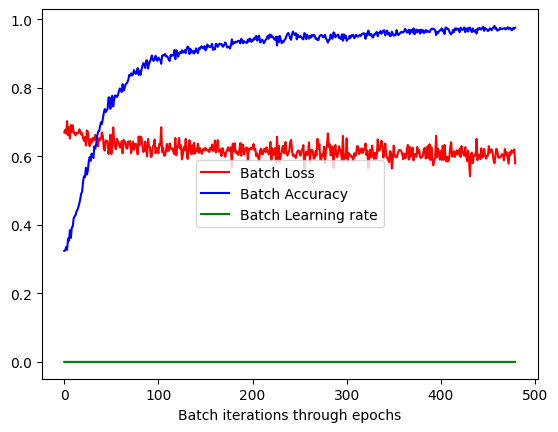

In [125]:
import matplotlib.pyplot as plt

train_acc_history_cpu = [t.cpu() for t in train_acc_history]

# Scatter plot
time_axis = np.arange(len(train_loss_history))
plt.plot(time_axis, train_loss_history, label='Batch Loss', color='red')
plt.plot(time_axis, train_acc_history_cpu, label='Batch Accuracy', color='blue')
plt.plot(time_axis, lr_history, label='Batch Learning rate', color='green')

plt.xlabel('Batch iterations through epochs')
plt.legend()
plt.show()